Notebook Logistic Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Lineair Regression toepassen op de data

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/arifmia/heart-attack-risk-dataset


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- missing data oplossen 
- incorrect types controleren
- Numerische waarde standardizeren
- Categorische varaiabelen processen
- Feature engineering
- select features for modelling

In [341]:
# import van de diverse modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance

from sklearn.metrics import classification_report
from sklearn.metrics import  confusion_matrix, accuracy_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings


plot_graphs = False

In [342]:
# extra code overal gebruikt

# extra code – code to save the figures as high-res PNGs for the book
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_overzicht_kolommen(df_plot, num_columns = 3, figuur_naam = 'Overzicht kolommen', bins = 50):    
    num_plots = len(df_plot.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df_plot.columns):
        df_plot[column].hist(bins, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()    
    if plot_graphs:
        save_fig(figuur_naam)
        plt.show()


def plot_histogram_old(df_hist, column, bins = 50, figuur_naam = 'Overzicht kolommen'):
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=14)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    # plt.hist(df_hist[column], color='blue', alpha=0.7)
    plt.title('Histogram van Heart Rate')
    plt.xlabel('Heart Rate')
    plt.ylabel('Frequentie')
    if plot_graphs:
        df_hist[column].hist(bins, figsize=(12, 8))
        save_fig(figuur_naam)  # extra code
    plt.show()



def plot_histogram(dataframe, column, bins=20, color='blue', title='', xlabel='', ylabel='Frequentie', filenaam = "Histogram"):
    """
    Deze functie plot een histogram van een gespecificeerde kolom uit een pandas DataFrame.
    
    Parameters:
        dataframe (pd.DataFrame): Het DataFrame dat de data bevat.
        column (str): De naam van de kolom waarvan een histogram moet worden geplot.
        bins (int): Het aantal bins (groepen) voor het histogram.
        color (str): De kleur van de histogram bars.
        title (str): De titel van de plot.
        xlabel (str): De label voor de x-as.
        ylabel (str): De label voor de y-as.
    """
    # Controleer of de kolom bestaat in het DataFrame
    if column not in dataframe.columns:
        print(f"Kolom '{column}' niet gevonden in het DataFrame.")
        return

    # Plot het histogram
    plt.hist(dataframe[column], bins=bins, color=color, alpha=0.7)
    plt.title(title if title else f'Histogram van {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    if plot_graphs:
        save_fig(filenaam)
        plt.show()

In [343]:
# data inlezen van de file

df = pd.read_csv('data/heart_attack_risk_dataset.csv')

# lijst met features opgedeeld in numerisch en categorisch
df_col = ['Age', 'Gender', 'Smoking', 'Alcohol_Consumption',
       'Physical_Activity_Level', 'BMI', 'Diabetes', 'Hypertension',
       'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Family_History',
       'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar',
       'ECG_Results', 'Exercise_Induced_Angina', 'Max_Heart_Rate_Achieved',
       'Heart_Attack_Risk']

# bepaal eerst de opdeling van numerische en categorische waarden op basis van de kolommen
# 3 opties

# optie 1: op basis van het datatype in de kolome
# df_num_col = df.select_dtypes(include='number').columns
# df_cat_col = df.select_dtypes(include='object').columns


# optie 2: op basis van de voorkomens van de waarden, indien <=4 is het een categorische 
# minder goed
df_cat_col = [i for i in df.columns if df[i].nunique() <= 4]
df_num_col= [i for i in df.columns if i not in df_cat_col]

# optie 3: en dit is de manuele manier om de lijst van kolommen voor numerische en categorische waarden samen te stellen
# check in via info() en describe() 
# we gaan dit verder gebruiken
df_num_col = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']
df_cat_col = ['Gender', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Diabetes', 'Hypertension', 'Family_History', 'Stress_Level',
              'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar','ECG_Results', 'Exercise_Induced_Angina', 'Heart_Attack_Risk']
df_label_col = ['Heart_Attack_Risk'] # dit is de te voorspellen waarde
df_cat_nom_col = ['Gender', 'Physical_Activity_Level', 'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'ECG_Results', 'Heart_Attack_Risk']
df_cat_ord_col = list(set(df_cat_col) - set(df_cat_nom_col))

df_num = df[df_num_col]
df_cat = df[df_cat_col]
df_label = df[df_label_col]
df_cat_nom = df[df_cat_nom_col]
df_cat_ord = df[df_cat_ord_col]


print("df_num")
print(df_num.head())


print("df_cat")
print(df_cat.head())


print("df_cat_nom")
print(df_cat_nom.head())


print("df_cat_ord")
print(df_cat_ord.head())

print("df_label")
print(df_label.head())

df_num
   Age    BMI  Cholesterol_Level  Resting_BP  Heart_Rate  \
0   69  34.61              152.1         171          85   
1   32  22.75              166.8         126         103   
2   89  35.32              272.3         123         127   
3   78  18.23              237.7         144         125   
4   38  19.82              207.7         123         107   

   Max_Heart_Rate_Achieved  
0                      114  
1                      173  
2                      109  
3                      129  
4                      124  
df_cat
   Gender  Smoking  Alcohol_Consumption Physical_Activity_Level  Diabetes  \
0  Female        1                    0                Moderate         1   
1    Male        0                    0                Moderate         0   
2    Male        0                    1                Moderate         0   
3    Male        0                    1                Moderate         1   
4  Female        1                    0                Moderate   

In [344]:
# eerste controles van alle waarden: 
# zijn er nulwaarden?
# zitten er geen duplicates tussen?

df.head()
df.describe()
df.info()

print(df.columns)

# check op nulwaarden:
df.isnull().sum()
# ok, geen nulwaarden

df.duplicated().sum()
# ok, geen duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      50000 non-null  int64  
 1   Gender                   50000 non-null  object 
 2   Smoking                  50000 non-null  int64  
 3   Alcohol_Consumption      50000 non-null  int64  
 4   Physical_Activity_Level  50000 non-null  object 
 5   BMI                      50000 non-null  float64
 6   Diabetes                 50000 non-null  int64  
 7   Hypertension             50000 non-null  int64  
 8   Cholesterol_Level        50000 non-null  float64
 9   Resting_BP               50000 non-null  int64  
 10  Heart_Rate               50000 non-null  int64  
 11  Family_History           50000 non-null  int64  
 12  Stress_Level             50000 non-null  object 
 13  Chest_Pain_Type          50000 non-null  object 
 14  Thalassemia           

np.int64(0)

In [345]:
# We nemen eerst een snelle blik op de variabelen via een histogram plot van alle features
# We maken een algemene plot van de variabelen


if plot_graphs:
    num_columns = 3
    num_plots = len(df.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df.columns):
        df[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("algemeen_overzicht_features")
    plt.show()

C:\Users\geert\AppData\Local\Temp\ipykernel_38700\2756940346.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38700\2756940346.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38700\2756940346.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38700\2756940346.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38700\2756940346.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\g

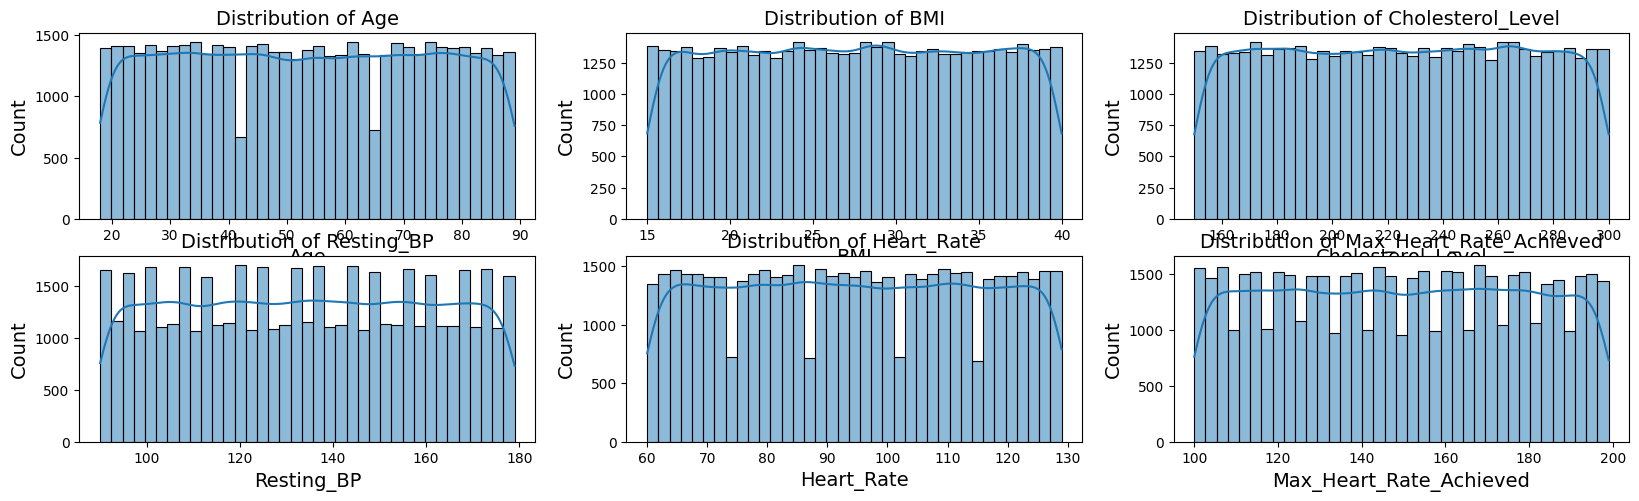

In [346]:
# analyze van de features, eerst de numerische features
# eerst een boxplot, voor de numerische waarde

# eerste een box-plot van de numerische variabelen
if plot_graphs:
    fig = plt.figure(figsize=(30,10))
    sns.boxplot(df_num)
    save_fig("Numerische features boxplot van de features")
    plt.show()
# Dit lijkt een normale verdeling. Er is hier geen log-verfijning nodig
# Er zijn ook geen outliers


# We maken nog een apart histogram van de numersiche variabelen
plt.figure(figsize=(20,14))
for i, col in enumerate(df_num_col,1):
    plt.subplot(5,3,i)
    sns.histplot(df[col], kde=True, palette='skyblue')
    plt.title(f"Distribution of {col}")
if plot_graphs:
    plt.tight_layout()
    save_fig("Numerische features histogram van de features")
    plt.show()
# Alles lijkt ook hier normaal


# Is er een correlatie tussen de numerische variabelen?
# Create corraltion heatmap
if plot_graphs:
    fig = plt.figure(figsize=(30,30))
    sns.heatmap(df_num.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
    save_fig("Numerische features: heatmap van de correlatie")
    plt.show()

In [347]:
# is er een correlatie tussen de numerische variabelen en de target value?
# hiervoor gaan we even de target valeu mappen naar een numerische waarde
df_corr = pd.concat([df_num, df[df_label_col]], axis=1)
df_corr.Heart_Attack_Risk = df_corr.Heart_Attack_Risk.map({'Low':1,'Moderate':2,'High':3})
df_corr.head()

if plot_graphs:
    fig = plt.figure(figsize=(30,30))
    sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
    save_fig("Numerische features: heatmap van de correlatie")
    plt.show()


# mmm, precies toch niet zo heel veel...


In [348]:
# analyze van de features, de categorische features

print(df_cat.head())
print(df_cat.describe())

   Gender  Smoking  Alcohol_Consumption Physical_Activity_Level  Diabetes  \
0  Female        1                    0                Moderate         1   
1    Male        0                    0                Moderate         0   
2    Male        0                    1                Moderate         0   
3    Male        0                    1                Moderate         1   
4  Female        1                    0                Moderate         0   

   Hypertension  Family_History Stress_Level Chest_Pain_Type  \
0             0               0     Moderate     Non-anginal   
1             0               0          Low    Asymptomatic   
2             0               0          Low         Typical   
3             0               0          Low         Typical   
4             0               0         High    Asymptomatic   

         Thalassemia  Fasting_Blood_Sugar                   ECG_Results  \
0  Reversible defect                    0                        Normal   
1 

In [349]:
# maak per categorsiche variabeel een bar_plot van de voorkomens van de waarden

def bar_labels(axes, rotation= 0, location="edge"):
    for container in axes.containers:
        axes.bar_label(container, rotation=rotation, label_type=location)
    axes.set_ylabel("")
    axes.set_xlabel("")
    axes.set_yticklabels(())

# plot de categorische waarde af met het voorkomen van de waarde in de dataset
# 14 plots, opgedeeld in 2 rijen met 7 plots

if plot_graphs:
    index = 0
    for r in range(2):
        fig, axes = plt.subplots(ncols=7, figsize=(15, 6))
        for i in range(7):
            df[df_cat_col[index]].value_counts().plot(kind="bar", ax=axes[i])
            bar_labels(axes[i])
            axes[i].set_title(df_cat_col[index].replace('_', ' '))
            
            index+=1      
        plt.tight_layout()   
        save_fig(f"Categorische features value count van de feature deel{r}")
        plt.show()


In [ ]:
# visuele voorstellen van de unbalance van de categorische variabelen







In [350]:
# en nu gaan we op basis van de target value ("Heart risk") groeperen en kijken wat de impact is van de diverse
# categorische variabelen

index = 0

grouped = df.groupby(df_label_col)

# plot 13 grafieken, 
if plot_graphs:
    for j in [5, 4, 4]:
        fig, axes = plt.subplots(ncols=j, figsize=(15, 6))
        for i in range(j):
            grouped[df_cat_col[index]].value_counts().unstack().plot(kind="bar", stacked=True, ax=axes[i])
            bar_labels(axes[i], 0, "center")
            axes[i].set_title(df_cat_col[index].replace('_', ' '))
            index+=1
        plt.tight_layout()
        save_fig(f"Categorische features per value van de target value deel {r}")
        plt.show()

In [351]:
# we gaan de nominale categorische variabelen omzetten naar een cijfer.
# Via de OneHotEncoding. 
# Voor de feature "Heart risk" doen we een aparte encoding

# print(df_cat.value_counts().sort_values(ascending=False).head(40))


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
ordinal_encoder = OrdinalEncoder()

# hier zouden we kunnen splitsen tussen de nominale categorische waarden en de ordinall
# bv smoking heeft reeds een waarde van 0 en 1, Diabetes
# maar we gaan alle nominale categorische waarden toch via oneHotEncoding transformeren



df_cat_to_encode = df_cat.drop(columns=df_label_col)
cat_encoded = onehot_encoder.fit_transform(df_cat_to_encode)
# dit geeft een numpy arrry terug
cat_encoded


labels = onehot_encoder.get_feature_names_out()
labels.shape
cat_encoded.shape

# print(onehot_encoder.get_feature_names_out())
# print()

# en we moeten daar terug een dataframe van maken
df_cat_encoded = pd.DataFrame(onehot_encoder.transform(df_cat_to_encode),
                        columns=onehot_encoder.get_feature_names_out(),
                        index=df_cat_to_encode.index)

print(df_cat_encoded.head())
print(df_cat_encoded.shape)



   Gender_Female  Gender_Male  Smoking_0  Smoking_1  Alcohol_Consumption_0  \
0            1.0          0.0        0.0        1.0                    1.0   
1            0.0          1.0        1.0        0.0                    1.0   
2            0.0          1.0        1.0        0.0                    0.0   
3            0.0          1.0        1.0        0.0                    0.0   
4            1.0          0.0        0.0        1.0                    1.0   

   Alcohol_Consumption_1  Physical_Activity_Level_High  \
0                    0.0                           0.0   
1                    0.0                           0.0   
2                    1.0                           0.0   
3                    1.0                           0.0   
4                    0.0                           0.0   

   Physical_Activity_Level_Low  Physical_Activity_Level_Moderate  Diabetes_0  \
0                          0.0                               1.0         0.0   
1                     

In [352]:
# feature scaling

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
num_min_max_scaled = min_max_scaler.fit_transform(df_num)

df_num_min_max_scaled = pd.DataFrame(num_min_max_scaled,
                        columns=df_num_col,
                        index=df_num.index)


if plot_graphs:
    num_columns = 3
    num_plots = len(df_num_min_max_scaled.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df_num_min_max_scaled.columns):
        df_num_min_max_scaled[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("Numercal features na min-max_scaling")
    plt.show()

    plot_histogram(df_num_min_max_scaled,"Age")


In [353]:
# Laatste stap van de feature preparatie, alles terug samen voegen# 
# de scaled numerische waarde : df_num_min_max_scaled
# de onehot encode categorische waarden : df_cat_encoded

print(df_cat_encoded.head())

X = pd.concat([df_num_min_max_scaled, df_cat_encoded], axis=1)
y = df['Heart_Attack_Risk']

print(X.head())
print(y.head())






   Gender_Female  Gender_Male  Smoking_0  Smoking_1  Alcohol_Consumption_0  \
0            1.0          0.0        0.0        1.0                    1.0   
1            0.0          1.0        1.0        0.0                    1.0   
2            0.0          1.0        1.0        0.0                    0.0   
3            0.0          1.0        1.0        0.0                    0.0   
4            1.0          0.0        0.0        1.0                    1.0   

   Alcohol_Consumption_1  Physical_Activity_Level_High  \
0                    0.0                           0.0   
1                    0.0                           0.0   
2                    1.0                           0.0   
3                    1.0                           0.0   
4                    0.0                           0.0   

   Physical_Activity_Level_Low  Physical_Activity_Level_Moderate  Diabetes_0  \
0                          0.0                               1.0         0.0   
1                     

In [354]:
# print histogrammen na feature preparation


if plot_graphs:
    num_plots = len(X.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(X.columns):
        X[column].hist(bins=50, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig("Feature preparation resultaat")
    plt.show()

In [356]:
# eerste logreg 
# splits de data set op training en test sets

smote = SMOTE(random_state=0)
X_sampled, y_sampled = smote.fit_resample(X,y)
#X_sampled = X.copy()
#y_sampled = y.copy()


X_train,X_test,y_train,y_test = train_test_split(X_sampled,y_sampled, test_size=0.2, random_state=42)

# voor een log regression uit
model_logreg= LogisticRegression()
model_logreg.fit(X_train,y_train)

y_pred = model_logreg.predict(X_test)
report = classification_report(y_test, y_pred)

print("\n\n")
print("**********************************")
print("    Logistic regression output"    )
print("**********************************")
print("Classification Report ")
print(report)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# decision tree model
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train,y_train)
y_pred = model_decision_tree.predict(X_test)
report = classification_report(y_test, y_pred)

print("\n\n")
print("**********************************")
print("    Decision Tree Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report ")
print(report)
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


# random forest model
model_random_forest = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,    # Maximum depth of the tree (default None for no limit)
    random_state=42,   # Ensures reproducibility
    class_weight='balanced'  # Handles class imbalance
)

# Train the model
model_random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_random_forest.predict(X_test)

# Evaluate the model
print("\n\n")
print("**********************************")
print("    Random Forrest Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))




# GridSearch

scoring = { 'accuracy', 'precision', 'recall', 'f1'}

params = {
    'max_depth':[None, 5, 6],
'min_samples_leaf':[1,2, 3],
'min_samples_split':[2,3]
}
gscv_dt = GridSearchCV(model_decision_tree, params, scoring=scoring, cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
print("\n\n")
print("**********************************")
print("    Random Forrest Classifier      ")
print("**********************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))








**********************************
    Logistic regression output
**********************************
Classification Report 
              precision    recall  f1-score   support

        High       0.35      0.39      0.37      5058
         Low       0.34      0.33      0.34      4987
    Moderate       0.34      0.32      0.33      4970

    accuracy                           0.35     15015
   macro avg       0.35      0.35      0.35     15015
weighted avg       0.35      0.35      0.35     15015


Accuracy Score:
0.3464535464535465
**********************************
    Decision Tree Classifier      
**********************************
Confusion Matrix:
[[2553 1200 1305]
 [1240 2144 1603]
 [1357 1557 2056]]
Classification Report 
              precision    recall  f1-score   support

        High       0.50      0.50      0.50      5058
         Low       0.44      0.43      0.43      4987
    Moderate       0.41      0.41      0.41      4970

    accuracy                           0

In [365]:
# Nu met hyper parameter tuning

# GridSearch

# Create and fit the model Logistic Regression

# Specify scoring metrics
model_logistic_regression = LogisticRegression()

# Specify parameter grid to try
params = {
    'max_iter':[100, 200,500],
    'C':[0.1, 1, 10, 100],
    'fit_intercept':[True]
}

# GridSearchCV met 5 fold cross validation. Use f1 as evaluation metric
gscv_lr = GridSearchCV(model_logistic_regression, params, scoring="precision", cv=5, refit='f1')
gscv_lr.fit(X_train, y_train)
y_pred = gscv_lr.best_estimator_.predict(X_test)

print("************************************")
print("    GridSearch Logistic Regression  ")
print("************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


c:\Users\geert\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\geert\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\geert\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\geert\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
 

************************************
    GridSearch Logistic Regression  
************************************
Confusion Matrix:
[[1978 1560 1520]
 [1805 1636 1546]
 [1798 1584 1588]]

Classification Report:
              precision    recall  f1-score   support

        High       0.35      0.39      0.37      5058
         Low       0.34      0.33      0.34      4987
    Moderate       0.34      0.32      0.33      4970

    accuracy                           0.35     15015
   macro avg       0.35      0.35      0.35     15015
weighted avg       0.35      0.35      0.35     15015


Accuracy Score:
0.3464535464535465


In [367]:
model_decision_tree = DecisionTreeClassifier()
scoring = { 'accuracy', 'precision', 'recall', 'f1'}

params = {
    'max_depth':[None, 5, 6],
    'min_samples_leaf':[1,2, 3],
    'min_samples_split':[2,3]
}

gscv_dt = GridSearchCV(model_decision_tree, params, scoring="accuracy", cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
y_pred = gscv_dt.best_estimator_.predict(X_test)

print("************************************")
print(" GridSearch Decision Tree Regression")
print("************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


************************************
 GridSearch Decision Tree Regression
************************************
Confusion Matrix:
[[2537 1197 1324]
 [1287 2100 1600]
 [1366 1542 2062]]

Classification Report:
              precision    recall  f1-score   support

        High       0.49      0.50      0.50      5058
         Low       0.43      0.42      0.43      4987
    Moderate       0.41      0.41      0.41      4970

    accuracy                           0.45     15015
   macro avg       0.45      0.45      0.45     15015
weighted avg       0.45      0.45      0.45     15015


Accuracy Score:
0.4461538461538462


In [368]:
model_random_forest = RandomForestClassifier()

params = {
    'max_depth':[None, 5],
'min_samples_leaf':[2],
'min_samples_split':[3],
    'n_estimators':[500]
}

gscv_dt = GridSearchCV(model_random_forest, params, scoring="accuracy", cv=5, refit='f1')
gscv_dt.fit(X_train, y_train)
y_pred = gscv_dt.best_estimator_.predict(X_test)

print("***************************************")
print(" GridSearch Random Forest Regression   ")
print("***************************************")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


***************************************
 GridSearch Random Forest Regression   
***************************************
Confusion Matrix:
[[3513 1314  231]
 [ 211 4064  712]
 [ 591 1920 2459]]

Classification Report:
              precision    recall  f1-score   support

        High       0.81      0.69      0.75      5058
         Low       0.56      0.81      0.66      4987
    Moderate       0.72      0.49      0.59      4970

    accuracy                           0.67     15015
   macro avg       0.70      0.67      0.67     15015
weighted avg       0.70      0.67      0.67     15015


Accuracy Score:
0.6683982683982684
